<div style="
    color: blue; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 40px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
    ML Modeling
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


# Tuning Class

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

def get_X_Y (exception_countries = []):
    df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

    # delete called countries:
    for iso_code in exception_countries:
        df = df[df["iso_code"] != iso_code]
    df = df.reset_index(drop=True)
    
    country_num = int(len(df["iso_code"].unique()))
    
    df.drop(["iso_code", "week_no"], axis=1, inplace=True)
    #df.drop(columns=df.columns[0:1], axis=1, inplace=True)
    pop = df.iloc[0]["population"]
    last_country = df.iloc[country_num*176 - 1]
    print(last_country)
    cnt = df["population"].value_counts()
    
    # now we want to join datas together
    prediction_days_count = 2
    features_list = []
    X_list = []
    Y_list = []
    
    for i in range(country_num):  # 234 is number of countries
        for j in range(176):  # 176 is number of weeks we have
            row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
            features_list.append(row_list)
    
    for i in range((len(features_list) - prediction_days_count) + 1):
        fl = features_list[i]
        fl_len = len(features_list[i])
        this_population = features_list[i][fl_len - 1]
        for j in range(1, prediction_days_count):
            if this_population == features_list[i + j][fl_len - 1]:
                fl.extend(features_list[i + j])
            else:
                this_population = -1
                break
        if this_population != -1:
            X_list.append(fl)
            Y_list.append(features_list[(i + prediction_days_count) - 1][0])
    
    return X_list, Y_list, country_num

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

class Moldels_Tuning (object):
    def __init__ (self, X_list, Y_list, country_num, prediction_days_count, \
                  batch_count, batch_length, val_size):
        x_df = pd.DataFrame(X_list)
        self._min_max_scaler_X = preprocessing.MinMaxScaler()
        x_scaled = self._min_max_scaler_X.fit_transform(x_df)
        
        y_df = pd.DataFrame(Y_list)
        self._min_max_scaler_Y = preprocessing.MinMaxScaler()
        y_scaled = self._min_max_scaler_Y.fit_transform(y_df)
        
        X_scaled_list = x_scaled.tolist()
        Y_scaled_list = y_scaled.tolist()
        
        self._X_train, self._X_test, self._Y_train, self._Y_test = self.__train_test_splitter (X_scaled_list, Y_scaled_list, country_num,prediction_days_count, batch_count, batch_length)
        self.X_train = self._X_train
        self.X_test = self._X_test
        self.Y_train = self._Y_train
        self.Y_test = self._Y_test
        self._val_size = val_size

        # initial values
        # svm
        self.svm_rbf_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_rbf_losses_ = []
        self.svm_linear_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_linear_losses_ = []
        self.svm_poly_min_loss_params_ = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        self.svm_poly_losses_ = []

        # KNN
        self.KNN_min_loss_params_ = {"n_neighbor": None,
                          "p": None,
                          "weight": None,
                          "algorithm": None,
                          "leaf_size": None,
                          "min_loss_value": None}
        self.KNN_losses_ = []
        # Ada Bosst
        self.Ada_Boost_min_loss_params_ = {"n_estimator" : None,
                            "learning_rate" : None,
                            "random_state" : None,
                            "estimator" : None,
                            "min_loss_value" : None}
        self.Ada_Bosst_losses_ = []

        # Poly
        self.Poly_min_loss_params_ = {"degree": None,
                              "interaction_only": None,
                              "include_bias": None,
                              "min_loss_value": None}
        self.Poly_losses_ = []
    
        # Random Forrest:
        self.random_forrest_min_loss_params_ = {"n_estimator" : None,
                                "max_depth" : None,
                                "min_samples_split" : None,
                                "min_samples_leaf" : None,
                                "bootstrap" : None,
                                "random_state" : None,
                                "max_features" : None,
                                "min_loss_value" : None}
        self.random_forrset_losses_ = []
         # Stacking:
        self.Stacking_min_loss_params_ = {"estimators": None,
                                           "final_estimator": None,
                                           "min_loss_value": float('inf')}
        
    
    def __train_test_splitter(self, X, Y, country_num,prediction_days_count, batch_count, batch_length):
        xlen = len(X)
        xs_count_for_each_country = int(xlen / country_num)
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
        i = 0
        for i in range(country_num):
            j = 0
            for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
                X_train.append(X[j])
                Y_train.append(Y[j])
            while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
                for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                    X_test.append(X[k])
                    Y_test.append(Y[k])
                j += batch_length
                for k in range(j, j + steps):
                    X_train.append(X[k])
                    Y_train.append(Y[k])
                j += steps + 1
                while j < (i+1) * xs_count_for_each_country:
                    X_train.append(X[j])
                    Y_train.append(Y[j])
                    j += 1
        return X_train, X_test, Y_train, Y_test
    

    def __train_val_spliter (self, seed=0):
        X_train, X_val, Y_train, Y_val = train_test_split(self._X_train, self._Y_train, \
                                                          test_size=self._val_size, random_state=seed)
        X_tr = np.array(X_train)
        y_tr = np.array(Y_train).reshape(len(Y_train))
        X_val = np.array(X_val)
        y_val = np.array(Y_val).reshape(len(Y_val))
        return X_tr, y_tr, X_val, y_val
        
    def __loss_function (self, y_test, y_pred):
        return np.sqrt((np.sum(np.power(y_test - y_pred, 2)))/len(y_test))/y_test.mean()
    
    def __rescale_data(self, data):
        return self._min_max_scaler_Y.inverse_transform(np.array(data).reshape(-1, 1)).flatten()
    
    def __evaluate_model(self, model, X_tr, y_tr, X_val, y_val):
        y_pred_scaled = model.fit(X_tr, y_tr).predict(X_val)
        y_pred_rescaled = self.__rescale_data(y_pred_scaled)
        y_val_rescaled = self.__rescale_data(y_val)
    
        # deviding by 10:
        y_pred_rescaled /= 10
        y_val_rescaled /= 10
        
        return self.__loss_function (y_val_rescaled, y_pred_rescaled)
        
    def __evaluate_model_test (self, model, X_tr, y_tr, X_te, y_te, plot):
        y_pred_scaled = model.fit(X_tr, y_tr).predict(X_te)
        y_pred_rescaled = self.__rescale_data(y_pred_scaled)
        y_test_rescaled = self.__rescale_data(y_te)
    
        # deviding by 10:
        y_pred_rescaled /= 10
        y_test_rescaled /= 10
        if plot == True:
            self.__plot_model(y_pred_rescaled, y_test_rescaled, model)
        return self.__loss_function (y_test_rescaled, y_pred_rescaled)
    

    def __plot_model(self, y_pred_rescaled, y_test_rescaled, model):
        fig, ax = plt.subplots(1, 1, figsize=(18, 6))
        ax.plot(np.arange(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted')
        ax.plot(np.arange(len(y_pred_rescaled)), y_test_rescaled, alpha=0.6, label='True')
        ax.set_title(f"{model} Predictions vs True Values")
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

    def svm_tuning (self, kernel,
                    Cs,
                    epsilons,
                    gammas = [None],
                    degrees = [None],
                    coef0s = [None]):
        seed = 0
        min_loss_params = {"C": None,
                           "epsilon": None,
                           "gamma": None,
                           "degree": None,
                           "coef0": None,
                           "min_loss_value": None}
        losses = []
        for C in Cs:
            for epsilon in epsilons:
                for gamma in gammas:    
                    for degree in degrees:
                        for coef0 in coef0s:
                            if kernel == "rbf":
                                svr = SVR (kernel = kernel, C=C, gamma = gamma, epsilon = epsilon)
                            elif kernel == "linear":
                                svr = SVR (kernel = kernel, C=C, epsilon = epsilon)
                            elif kernel == "poly":
                                svr = SVR (kernel = kernel, C=C, gamma = gamma,
                                           epsilon = epsilon, degree=degree, coef0=coef0)
                            else:
                                print ("please use valid kernel.")
                                return
                            X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                            loss = self.__evaluate_model (model=svr,
                                                   X_tr=X_tr,
                                                   y_tr=y_tr,
                                                   X_val=X_val,
                                                   y_val=y_val)
                            if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                                min_loss_params["C"] = C
                                min_loss_params["epsilon"] = epsilon
                                min_loss_params["gamma"] = gamma
                                min_loss_params["degree"] = degree
                                min_loss_params["coef0"] = coef0
                                min_loss_params["min_loss_value"] = loss
                            losses.append(loss)
                            seed += 1
        if kernel == "rbf":
            self.svm_rbf_min_loss_params_ = min_loss_params
            self.svm_rbf_losses_ = losses
        elif kernel == "linear":
            self.svm_linear_min_loss_params_ = min_loss_params
            self.svm_linear_losses_ = losses
        elif kernel == "poly":
            self.svm_poly_min_loss_params_ = min_loss_params
            self.svm_poly_losses_ = losses
        return
    
    def svm_score (self, kernel):
        if kernel == "rbf":
            if self.svm_rbf_min_loss_params_["min_loss_value"] != None:
                C = self.svm_rbf_min_loss_params_["C"]
                epsilon = self.svm_rbf_min_loss_params_["epsilon"]
                gamma = self.svm_rbf_min_loss_params_["gamma"]
                coef0 = self.svm_rbf_min_loss_params_["coef0"]
                svr = SVR (kernel = kernel, C=C, gamma = gamma, epsilon = epsilon)
                loss_value = self.__evaluate_model_test (model=svr, X_te=self._X_test, X_tr=self._X_train, y_tr=self._Y_train,
                                            y_te=self._Y_test, plot=True)
                return loss_value

        elif kernel == "linear":
            if self.svm_linear_min_loss_params_["min_loss_value"] != None:
                C = self.svm_linear_min_loss_params_["C"]
                epsilon = self.svm_linear_min_loss_params_["epsilon"]
                svr = SVR (kernel = kernel, C=C, epsilon = epsilon)
                loss_value = self.__evaluate_model_test (model=svr, X_te=self._X_test, X_tr=self._X_train, y_tr=self._Y_train,
                                            y_te=self._Y_test, plot=True)
                return loss_value
        elif kernel == "poly":
            if self.svm_poly_min_loss_params_["min_loss_value"] != None:
                C = self.svm_poly_min_loss_params_["C"]
                epsilon = self.svm_poly_min_loss_params_["epsilon"]
                degree = self.svm_poly_min_loss_params_["degree"]
                gamma = self.svm_poly_min_loss_params_["gamma"]
                coef0 = self.svm_poly_min_loss_params_["coef0"]
                svr = SVR (kernel = kernel, C=C, gamma = gamma,
                                           epsilon = epsilon, degree=degree, coef0=coef0)
                loss_value = self.__evaluate_model_test (model=svr, X_te=self._X_test, X_tr=self._X_train, y_tr=self._Y_train,
                                            y_te=self._Y_test, plot=True)
                return loss_value
        return
    
    def KNN_tuning (self, n_neighbors,
                    ps=[1,2],
                    weights=['uniform', 'distance'],
                    algorithms=['auto', 'ball_tree', 'kd_tree', 'brute'],
                    leaf_sizes=[30]):
        seed = 0
        min_loss_params= {"n_neighbor": None,
                          "p": None,
                          "weight": None,
                          "algorithm": None,
                          "leaf_size": None,
                          "min_loss_value": None}
        losses = []
        for n_neighbor in n_neighbors:
            for p in ps:
                for weight in weights:
                    for algorithm in algorithms:
                        for leaf_size in leaf_sizes:
                            knn = KNeighborsRegressor(n_neighbors=n_neighbor,
                                                      p=p,
                                                      weights=weight,
                                                      algorithm=algorithm,
                                                      leaf_size=leaf_size)
                            X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                            loss = self.__evaluate_model (model=knn,
                                                   X_tr=X_tr,
                                                   y_tr=y_tr,
                                                   X_val=X_val,
                                                   y_val=y_val)
                            if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                                min_loss_params["n_neighbor"] = n_neighbor
                                min_loss_params["p"] = p
                                min_loss_params["weight"] = weight
                                min_loss_params["algorithm"] = algorithm
                                min_loss_params["leaf_size"] = leaf_size
                                min_loss_params["min_loss_value"] = loss
                            losses.append(loss)
                            seed += 1
        self.KNN_min_loss_params_ = min_loss_params
        self.KNN_losses_ = losses
        return

    def KNN_score (self):
        if self.KNN_min_loss_params_["min_loss_value"] != None:
            n_neighbor = self.KNN_min_loss_params_["n_neighbor"]
            p = self.KNN_min_loss_params_["p"]
            weight = self.KNN_min_loss_params_["weight"]
            algorithm = self.KNN_min_loss_params_["algorithm"]
            leaf_size = self.KNN_min_loss_params_["leaf_size"]
            knn = KNeighborsRegressor(n_neighbors=n_neighbor,
                                                      p=p,
                                                      weights=weight,
                                                      algorithm=algorithm,
                                                      leaf_size=leaf_size)
            loss_value = self.__evaluate_model_test (model=knn, X_tr=self._X_train, y_tr=self._Y_train, X_te=self._X_test,
                                        y_te=self._Y_test, plot=True)
            return loss_value
        return
            
    def Poly_tuning (self, degrees,
                     interaction_onlies = [True, False],
                     include_biases = [True, False]):
        seed = 0
        min_loss_params= {"degree": None,
                          "interaction_only": None,
                          "include_bias": None,
                          "min_loss_value": None}
        losses = []
        for degree in degrees:
            for interaction_only in interaction_onlies:
                for include_bias in include_biases:
                    poly = PolynomialFeatures(degree=degree,
                                              interaction_only=interaction_only,
                                              include_bias=include_bias)
                    X_tr, y_tr, X_val, y_val = \
                                    self.__train_val_spliter(seed=seed)
                    X_poly_tr = poly.fit_transform(X_tr)
                    X_poly_val = poly.transform(X_val)

                    linear_model = LinearSVR(loss='squared_epsilon_insensitive',
                                             dual=False)
                    loss = self.__evaluate_model (model=linear_model,
                                           X_tr=X_poly_tr,
                                           y_tr=y_tr,
                                           X_val=X_poly_val,
                                           y_val=y_val)
                    if min_loss_params["min_loss_value"] == None \
                                or loss < min_loss_params["min_loss_value"]:
                        min_loss_params["degree"] = degree
                        min_loss_params["interaction_only"] = interaction_only
                        min_loss_params["include_bias"] = include_bias
                        min_loss_params["min_loss_value"] = loss
                    losses.append(loss)
                    seed += 1
        self.Poly_min_loss_params_ = min_loss_params
        self.Poly_losses_ = losses
        return
        
    def Poly_score(self):
        if self.Poly_min_loss_params_["min_loss_value"] != None:
            degree = self.Poly_min_loss_params_["degree"]
            interaction_only = self.Poly_min_loss_params_["interaction_only"]
            include_bias = self.Poly_min_loss_params_["include_bias"]
            poly = PolynomialFeatures(degree=degree,
                                              interaction_only=interaction_only,
                                              include_bias=include_bias)
            
            X_poly_te = poly.fit_transform(self._X_test)

            linear_model = LinearSVR(loss='squared_epsilon_insensitive',
                                     dual=False)
            loss_value = self.__evaluate_model_test (model=linear_model, X_tr=self._X_train, y_tr=self._Y_train, X_te=X_poly_te,
                                        y_te=self._Y_test, plot=True)
            return loss_value
        return
    
    def Ada_Boost_tuning (self, n_estimators,
                          learning_rates,
                          random_states = [0],
                          base_estimators = [None]):
        seed = 0
        min_loss_params = {"n_estimator" : None,
                            "learning_rate" : None,
                            "random_state" : None,
                            "estimator" : None,
                            "min_loss_value" : None}
        losses = []
        for n_estimator in n_estimators:
            for random_state in random_states:
                for learning_rate in learning_rates:
                    for base_estimator in base_estimators:
                        ada_boost_regr = AdaBoostRegressor(random_state=random_state,
                                                           n_estimators=n_estimator,
                                                           learning_rate=learning_rate,
                                                           estimator=base_estimator)
                        X_tr, y_tr, X_val, y_val = \
                                        self.__train_val_spliter(seed=seed)
    
                        loss = self.__evaluate_model (model=ada_boost_regr,
                                               X_tr=X_tr,
                                               y_tr=y_tr,
                                               X_val=X_val,
                                               y_val=y_val)
                        if min_loss_params["min_loss_value"] == None \
                                    or loss < min_loss_params["min_loss_value"]:
                            min_loss_params["n_estimator"] = n_estimator
                            min_loss_params["learning_rate"] = learning_rate
                            min_loss_params["random_state"] = random_state
                            min_loss_params["estimator"] = base_estimator
                            min_loss_params["min_loss_value"] = loss
                        losses.append(loss)
                        seed += 1
        
        self.Ada_Boost_min_loss_params_ = min_loss_params
        self.Ada_Bosst_losses_ = losses
        return

    def Ada_Boost_score (self):
        if self.Ada_Boost_min_loss_params_["min_loss_value"] != None:
            n_estimator = self.Ada_Boost_min_loss_params_["n_estimator"]
            learning_rate = self.Ada_Boost_min_loss_params_["learning_rate"]
            random_state = self.Ada_Boost_min_loss_params_["random_state"]
            estimator = self.Ada_Boost_min_loss_params_["estimator"]
            ada_boost_regr = AdaBoostRegressor(random_state=random_state,
                                                           n_estimators=n_estimator,
                                                           learning_rate=learning_rate,
                                                           estimator=base_estimator)
            loss_value = self.__evaluate_model_test (model=ada_boost_regr, X_tr=self._X_train, y_tr=self._Y_train,
                                                     X_te=self._X_test,
                                                     y_te=self._Y_test, plot=True)
            return loss_value
        return
    
    def random_forrest_tuning (self, n_estimators,
                               max_features = [1.0],
                               max_depths = [None],
                               min_samples_splits = [2],
                               min_samples_leaves = [1],
                               bootstraps = [True, False],
                               random_states = [0]):
        seed = 0
        min_loss_params = {"n_estimator" : None,
                            "max_depth" : None,
                            "min_samples_split" : None,
                            "min_samples_leaf" : None,
                            "bootstrap" : None,
                            "random_state" : None,
                            "max_features" : None,
                            "min_loss_value" : None}
        losses = []
        for n_estimator in n_estimators:
            for max_feature in max_features:
                for max_depth in max_depths:
                    for min_samples_leaf in min_samples_leaves:
                        for bootstrap in bootstraps:
                            for random_state in random_states:
                                for min_samples_split in min_samples_splits:
                                    random_forrest_regr =  RandomForestRegressor(n_estimators=n_estimator,
                                                                max_depth=max_depth,
                                                                random_state=random_state,
                                                                max_features=max_feature,
                                                                min_samples_leaf=min_samples_leaf,
                                                                min_samples_split=min_samples_split,
                                                                bootstrap=bootstrap)
                                    X_tr, y_tr, X_val, y_val = \
                                                    self.__train_val_spliter(seed=seed)
                
                                    loss = self.__evaluate_model (model=random_forrest_regr,
                                                           X_tr=X_tr,
                                                           y_tr=y_tr,
                                                           X_val=X_val,
                                                           y_val=y_val)
                                    if min_loss_params["min_loss_value"] == None \
                                                or loss < min_loss_params["min_loss_value"]:
                                        min_loss_params["n_estimator"] = n_estimator
                                        min_loss_params["max_depth"] = max_depth
                                        min_loss_params["min_samples_split"] = min_samples_split
                                        min_loss_params["min_samples_leaf"] = min_samples_leaf
                                        min_loss_params["bootstrap"] = bootstrap
                                        min_loss_params["random_state"] = random_state
                                        min_loss_params["max_features"] = max_feature
                                        min_loss_params["min_loss_value"] = loss
                                    losses.append(loss)
                                    seed += 1          
        self.random_forrest_min_loss_params_ = min_loss_params
        self.random_forrset_losses_ = losses
        return

    def random_forrest_score (self):
        if self.random_forrest_min_loss_params_["min_loss_value"] != None:
            n_estimator = self.random_forrest_min_loss_params_["n_estimator"]
            max_depth = self.random_forrest_min_loss_params_["max_depth"]
            min_samples_split = self.random_forrest_min_loss_params_["min_samples_split"]
            min_samples_leaf = self.random_forrest_min_loss_params_["min_samples_leaf"]
            bootstrap = self.random_forrest_min_loss_params_["bootstrap"]
            random_state = self.random_forrest_min_loss_params_["random_state"]
            max_features = self.random_forrest_min_loss_params_["max_features"]
            random_forrest_regr =  RandomForestRegressor(n_estimators=n_estimator,
                                                                max_depth=max_depth,
                                                                random_state=random_state,
                                                                max_features=max_feature,
                                                                min_samples_leaf=min_samples_leaf,
                                                                min_samples_split=min_samples_split,
                                                                bootstrap=bootstrap)
            loss_value = self.__evaluate_model_test (model=random_forrest_regr, X_tr=self._X_train, y_tr=self._Y_train,
                                                     X_te=self._X_test,
                                                     y_te=self._Y_test, plot=True)
            return loss_value
        return
    
    def Stacking_tuning(self, cv=5):
        seed = 0
        min_loss_params = {"estimators": None, "final_estimator": None, "min_loss_value": float('inf')}
        
        # Define the base estimators with their best hyperparameters
        knn_best = KNeighborsRegressor(
            n_neighbors=self.KNN_min_loss_params_['n_neighbor'],
            p=self.KNN_min_loss_params_['p'],
            weights=self.KNN_min_loss_params_['weight'],
            algorithm=self.KNN_min_loss_params_['algorithm'],
            leaf_size=self.KNN_min_loss_params_['leaf_size']
        )

        svm_best = SVR(
            kernel='poly',  # Assuming 'poly' is the best kernel 
            C=self.svm_rbf_min_loss_params_['C'],
            epsilon=self.svm_rbf_min_loss_params_['epsilon'],
            gamma=self.svm_rbf_min_loss_params_['gamma']
        )

        ada_best = AdaBoostRegressor(
            n_estimators=self.Ada_Boost_min_loss_params_['n_estimator'],
            learning_rate=self.Ada_Boost_min_loss_params_['learning_rate'],
            random_state=self.Ada_Boost_min_loss_params_['random_state']
        )

        rf_best = RandomForestRegressor(
            n_estimators=self.random_forrest_min_loss_params_['n_estimator'],
            max_depth=self.random_forrest_min_loss_params_['max_depth'],
            min_samples_split=self.random_forrest_min_loss_params_['min_samples_split'],
            min_samples_leaf=self.random_forrest_min_loss_params_['min_samples_leaf'],
            bootstrap=self.random_forrest_min_loss_params_['bootstrap'],
            random_state=self.random_forrest_min_loss_params_['random_state'],
            max_features=self.random_forrest_min_loss_params_['max_features']
        )

        # List of possible final estimators
        final_estimators = [
            LinearRegression(),
            SVR(),
            KNeighborsRegressor(),
            AdaBoostRegressor(),
            RandomForestRegressor()
        ]

        X_tr, y_tr, X_val, y_val = self.__train_val_spliter(seed=seed)
        
        for final_estimator in final_estimators:
            stacking_regressor = StackingRegressor(
                estimators=[
                    ('knn', knn_best),
                    ('svm', svm_best),
                    ('ada', ada_best),
                    ('rf', rf_best)
                ],
                final_estimator=final_estimator,
                cv=cv,
                n_jobs=-1,
                passthrough=True
            )

            loss = self.__evaluate_model(model=stacking_regressor, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)
            
            if loss < min_loss_params["min_loss_value"]:
                min_loss_params["estimators"] = stacking_regressor.estimators
                min_loss_params["final_estimator"] = final_estimator
                min_loss_params["min_loss_value"] = loss

            seed += 1
        
        self.Stacking_min_loss_params_ = min_loss_params
        return

    def Stacking_score (self, cv=5):
        if self.Stacking_min_loss_params_["min_loss_value"] != None:
            estimators = self.Stacking_min_loss_params_["estimators"]
            final_estimator = self.Stacking_min_loss_params_["final_estimator"]
            stacking_regressor = StackingRegressor(
                                                    estimators=estimators,
                                                    final_estimator=final_estimator,
                                                    cv=cv,
                                                    n_jobs=-1,
                                                    passthrough=True
                                                )
            loss_value = self.__evaluate_model_test (model=stacking_regressor, X_tr=self._X_train, y_tr=self._Y_train,
                                                     X_te=self._X_test,
                                                     y_te=self._Y_test, plot=True)
            return loss_value
        return

# Best Hyperparameters

In [59]:
X_list, Y_list, country_num = get_X_Y(["CHN"])

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41007, dtype: float64


In [60]:
prediction_days_count = 2

MT = Moldels_Tuning(X_list=X_list, Y_list=Y_list,
                    country_num=country_num,
                    prediction_days_count=prediction_days_count,
                    batch_count=3,
                    batch_length=10,
                    val_size=0.2)

## KNN

In [61]:
# MT.KNN_tuning([2, 3, 5], [1, 2, 3])
MT.KNN_tuning([2], [3], ['distance'], ['kd_tree'])

In [62]:
MT.KNN_min_loss_params_

{'n_neighbor': 2,
 'p': 3,
 'weight': 'distance',
 'algorithm': 'kd_tree',
 'leaf_size': 30,
 'min_loss_value': 1.5416204380581284}

0.9963993315283417

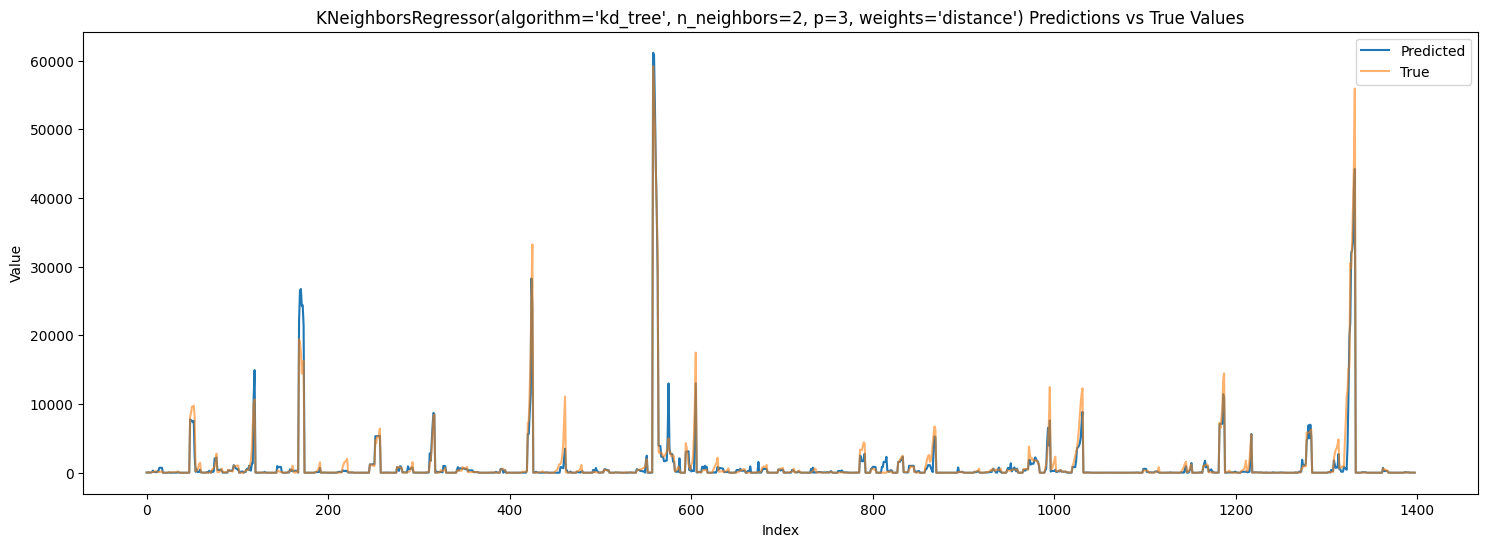

In [63]:
MT.KNN_score()

## svm

In [ ]:
MT.svm_tuning(kernel='linear', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='poly', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='rbf', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])

In [ ]:
MT.svm_linear_min_loss_params_

In [ ]:
MT.svm_score(kernel="linear")

In [ ]:
MT.svm_poly_min_loss_params_

In [ ]:
MT.svm_score(kernel="poly")

In [ ]:
MT.svm_rbf_min_loss_params_

In [ ]:
MT.svm_score(kernel="rbf")

## Polynomial

In [11]:
MT.Poly_tuning(degrees=[2, 3])

KeyboardInterrupt: 

In [ ]:
MT.Poly_min_loss_params_

In [ ]:
MT.Poly_score()

## Adaboost

In [12]:
MT.Ada_Boost_tuning(n_estimators=[50, 100, 200, 500], learning_rates=[0.01, 0.1, 0.5, 1])

In [13]:
MT.Ada_Boost_min_loss_params_

{'n_estimator': 50,
 'learning_rate': 0.1,
 'random_state': 0,
 'estimator': None,
 'min_loss_value': 0.0026250733564721603}

In [14]:
MT.Ada_Boost_score()

TypeError: Moldels_Tuning.Ada_Boost_score() takes 0 positional arguments but 1 was given

## Random-Forest

In [ ]:
MT.random_forrest_tuning(n_estimators=[50, 100, 200], max_features=['sqrt', 'log2'], max_depths=[1,3,6], min_samples_splits=[2, 5], min_samples_leaves=[1, 2])


In [ ]:
MT.random_forrest_min_loss_params_

In [ ]:
MT.random_forrest_score()

## stacking

In [ ]:
MT.Stacking_tuning()

In [ ]:
MT.Stacking_min_loss_params_

In [ ]:
MT.Stacking_score()

## Testing rescaling

In [ ]:
# #check to see if my rescaling is working as intended

# # Test scaling and rescaling
# sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
# print("Sample scaled values:", sample_y)

# rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
# print("Rescaled values:", rescaled_y)  

# original_y = [Y_list[0], Y_list[10], Y_list[100]]
# print("Original values:", original_y)

# # Check if rescaled values match the original values
# print("Match:", np.allclose(rescaled_y, original_y))

## Tuning function but not working as I except.

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor

# def evaluate_and_plot_models(models, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, rows_to_plot):
#     results = []

#     # Evaluate each model with its respective hyperparameters
#     for model_info in models:
#         model_type = model_info['type']
#         hyperparameters = model_info['params']
        
#         for hyperparam in hyperparameters:
#             if model_type == 'RandomForest':
#                 model = RandomForestRegressor(**hyperparam, random_state=0)
#             elif model_type == 'KNeighbors':
#                 model = KNeighborsRegressor(**hyperparam)
#             else:
#                 raise ValueError("Unsupported model type")
            
#             model_err_pred = evaluate_model(model, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, model_name=model_type, monitoring=False)
#             results.append((hyperparam,) + model_err_pred)

#             print(f"Process for {model_type} with {hyperparam} done.")

#     # Convert the list of results to a DataFrame
#     if models[0]['type'] == 'RandomForest':
#         columns = ["params", "MAE", "MSE", "y_pred", "y_test_rescaled"]
#     elif models[0]['type'] == 'KNeighbors':
#         columns = ["params", "MAE", "MSE", "y_pred", "y_test_rescaled"]
    
#     tuning_data_df = pd.DataFrame(results, columns=columns)

#     # Plotting
#     fig, axs = plt.subplots(1, len(rows_to_plot), figsize=(18, 6))

#     for i, row in enumerate(rows_to_plot):
#         y_pred = tuning_data_df.loc[row, "y_pred"]
#         y_test_rescaled = tuning_data_df.loc[row, "y_test_rescaled"]
#         params = tuning_data_df.loc[row, "params"]
#         model_name = f"{models[0]['type']} {params}"
#         print(f"For {params}: MAE = {tuning_data_df.loc[row, 'MAE']} , MSE = {tuning_data_df.loc[row, 'MSE']}")
#         plot_model(y_pred, y_test_rescaled, model_name, axs[i])

#     plt.tight_layout()
#     plt.show()

#     return tuning_data_df

# # Define the models and hyperparameters
# models = [
#     {
#         'type': 'RandomForest',
#         'params': [{'max_depth': depth} for depth in range(2, 10)]
#     },
#     {
#         'type': 'KNeighbors',
#         'params': [{'n_neighbors': k, 'p': p} for p in [1, 2, 3] for k in [2, 5, 10, 15]]
#     }
# ]

# # Call the function with the models and data
# tuning_data_df = evaluate_and_plot_models(models, X_tr, y_tr, X_te, y_te, min_max_scaler_Y, rows_to_plot=[0, 4, 7])


# Neighbors effect

in this part we are going to include the effect of the top 10 important neighbours of a country on the model and do the whole process again.

In [62]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
import math

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Load datasets
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")
interaction_matrix = pd.read_csv("../Data/Interaction_matrix/interaction_matrix.csv")
interaction_matrix.index = interaction_matrix.columns

# Preprocessing
df.drop(["week_no"], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

# Identify top 10 correlated countries for each country, ignoring invalid values
top_10_neighbors = {}
valid_countries = set(interaction_matrix.index)

for country in interaction_matrix.index:
    valid_correlations = interaction_matrix.loc[country].replace([-1, 0, np.nan], np.nan).dropna()
    if len(valid_correlations) >= 10:
        top_10_neighbors[country] = valid_correlations.nlargest(10).index.tolist()
    else:
        valid_countries.remove(country)

# Normalize interaction matrix for weights
normalized_interaction_matrix = interaction_matrix.div(interaction_matrix.max(axis=1), axis=0)

# Map countries to their indices in the data
country_indices = {df.iloc[i * 176]['iso_code']: i for i in range(234) if df.iloc[i * 176]['iso_code'] in valid_countries}

# Initialize feature and label lists
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

# Create feature list including neighboring country features with weighted effect
for i in range(234):  # 234 is the total number of countries
    country = df.loc[i * 176, 'iso_code']
    if country not in valid_countries:
        continue  # Skip countries not in the valid set

    neighbors = top_10_neighbors.get(country, [])
    
    for j in range(176):  # 176 is the number of weeks we have
        row_list = df.loc[i * 176 + j, :].values[1:].flatten().tolist()
        
        for neighbor in neighbors:
            if neighbor in country_indices:
                neighbor_index = country_indices[neighbor]
                weight = normalized_interaction_matrix.loc[country, neighbor]
                weighted_features = df.loc[neighbor_index * 176 + j, :].values[1:].flatten() * weight
                row_list.extend(weighted_features.tolist())
        
        features_list.append(row_list)

# Extend the features list for prediction days
for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


iso_code                             ZWE
new_cases                           75.0
new_deaths                           2.0
new_vaccinations                     0.0
new_people_vaccinated                0.0
reproduction_rate                   0.95
stringency_index                   87.96
excess_mortality                 -1000.0
population_density                42.729
median_age                          19.6
aged_65_older                      2.822
aged_70_older                      1.882
cardiovasc_death_rate            307.846
diabetes_prevalence                 1.82
female_smokers                       1.6
male_smokers                        30.7
hospital_beds_per_thousand           1.7
life_expectancy                    61.49
human_development_index            0.571
population                    16320539.0
Name: 41183, dtype: object


<div style="
    color: blue; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 40px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
    ML Modeling
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


# Best Hyperparameters

In [64]:
MT = Moldels_Tuning(X_list=X_list, Y_list=Y_list,
                    prediction_days_count=prediction_days_count,
                    batch_count=3,
                    batch_length=10,
                    val_size=0.2)

## KNN

In [65]:
MT.KNN_tuning([2, 3, 5], [1, 2, 3])

In [90]:
MT.KNN_min_loss_params_

{'n_neighbor': 2,
 'p': 1,
 'weight': 'distance',
 'algorithm': 'ball_tree',
 'leaf_size': 30,
 'min_loss_value': 2059.7004364142263}

In [ ]:
MT.KNN_score()

## svm

In [91]:
MT.svm_tuning(kernel='linear', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='poly', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])
MT.svm_tuning(kernel='rbf', Cs=[0.01, 0.1, 1, 10, 100],epsilons=[0.01, 0.05, 0.1, 0.2, 0.5] , gammas=[0.001, 0.01, 0.1, 1, 10], degrees=[2, 3, 4, 5], coef0s=[0, 0.1, 0.5, 1, 5])

In [92]:
MT.svm_linear_min_loss_params_

{'C': 100,
 'epsilon': 0.01,
 'gamma': 0.001,
 'degree': 4,
 'coef0': 0.1,
 'min_loss_value': 16908.20125623387}

In [ ]:
MT.svm_score(kernel="linear")

In [93]:
MT.svm_poly_min_loss_params_

{'C': 1,
 'epsilon': 0.01,
 'gamma': 0.1,
 'degree': 3,
 'coef0': 1,
 'min_loss_value': 17181.352220728666}

In [ ]:
MT.svm_score(kernel="poly")

In [94]:
MT.svm_rbf_min_loss_params_

{'C': 10,
 'epsilon': 0.01,
 'gamma': 0.01,
 'degree': 4,
 'coef0': 1,
 'min_loss_value': 20223.80328962984}

In [ ]:
MT.svm_score(kernel="rbf")

## Polynomial

In [103]:
MT.Poly_tuning(degrees=[1])

In [104]:
MT.Poly_min_loss_params_

{'degree': 1,
 'interaction_only': True,
 'include_bias': True,
 'min_loss_value': 2289.267098941311}

In [ ]:
MT.Poly_score()

## Adaboost

In [98]:
MT.Ada_Boost_tuning(n_estimators=[50, 100, 200, 500], learning_rates=[0.01, 0.1, 0.5, 1])

In [99]:
MT.Ada_Boost_min_loss_params_

{'n_estimator': 50,
 'learning_rate': 0.1,
 'random_state': 0,
 'estimator': None,
 'min_loss_value': 3842.6826828266435}

In [ ]:
MT.Ada_Boost_score()

## Random-Forest

In [100]:
MT.random_forrest_tuning(n_estimators=[50, 100, 200], max_features=['sqrt', 'log2'], max_depths=[1,3,6], min_samples_splits=[2, 5], min_samples_leaves=[1, 2])


In [101]:
MT.random_forrest_min_loss_params_

{'n_estimator': 200,
 'max_depth': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'bootstrap': False,
 'random_state': 0,
 'max_features': 'sqrt',
 'min_loss_value': 3855.443172052244}

In [ ]:
MT.random_forrest_score()

## stacking

In [105]:
MT.Stacking_tuning()

: 

In [ ]:
MT.Stacking_min_loss_params_

{'estimators': [('knn',
   KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')),
  ('svm', SVR(C=100, epsilon=0.01, gamma=0.01, kernel='poly')),
  ('ada', AdaBoostRegressor(learning_rate=0.01, random_state=0)),
  ('rf',
   RandomForestRegressor(bootstrap=False, max_depth=6, max_features='sqrt',
                         n_estimators=200, random_state=0))],
 'final_estimator': LinearRegression(),
 'min_loss_value': 4.0064016728198946e-10}

In [ ]:
MT.Stacking_score()

## Testing rescaling

In [ ]:
#check to see if my rescaling is working as intended

# Test scaling and rescaling
sample_y = [y_scaled[0], y_scaled[10], y_scaled[100]]
print("Sample scaled values:", sample_y)

rescaled_y = rescale_data(min_max_scaler_Y, sample_y)
print("Rescaled values:", rescaled_y)  

original_y = [Y_list[0], Y_list[10], Y_list[100]]
print("Original values:", original_y)

# Check if rescaled values match the original values
print("Match:", np.allclose(rescaled_y, original_y))

Sample scaled values: [array([0.]), array([4.20007403e-07]), array([4.44713721e-06])]
Rescaled values: [  0.  17. 180.]
Original values: [0.0, 17.0, 180.0]
Match: True


In [ ]:
for i in [1]:
    for j in [None]:
        print(i, j)

1 None
